In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium
from IPython.display import HTML
from datetime import datetime


In [2]:
all_data = pd.read_csv("../../../data/external/purpleair/slc_daily_pm2.5_pm10_2016to2024.csv")

array([[<Axes: title={'center': 'pm2.5_atm'}>]], dtype=object)

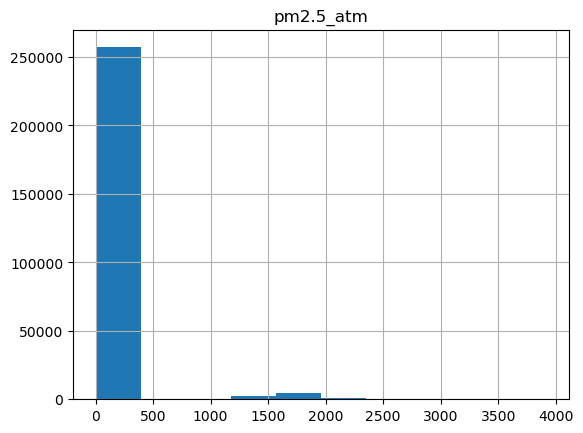

In [3]:
all_data.hist(column = 'pm2.5_atm', bins=10)

In [4]:
len(all_data[all_data['pm2.5_atm'] > 500]) / len(all_data)

0.031832005901925656

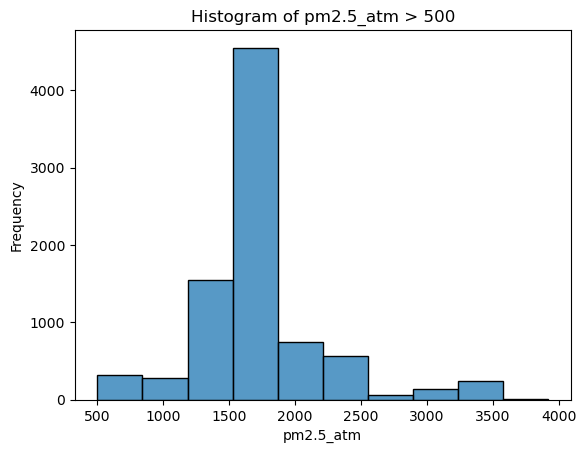

In [5]:
# filter data to pm2.5 > 500
filtered_data = all_data[all_data['pm2.5_atm'] > 500]

# plot histogram
sns.histplot(filtered_data['pm2.5_atm'], bins=10)
plt.xlabel('pm2.5_atm')
plt.ylabel('Frequency')
plt.title('Histogram of pm2.5_atm > 500')
plt.show()


In [6]:
sensor_outlier_counts = pd.DataFrame(all_data[all_data['pm2.5_atm'] > 500]['sensor_id'].value_counts()).reset_index()
sensor_outlier_counts.rename(columns = {'index': 'sensor_index', 'sensor_id': 'outlier_occurrences'}, inplace=True)
sensor_outlier_counts.head()

,sensor_index,outlier_occurrences
0,113612,873
1,129333,565
2,134552,561
3,120493,532
4,120419,524


In [7]:
# Calculate the column with values of outlier_occurrences divided by the total sum
sensor_outlier_counts['occurrences_ratio'] = sensor_outlier_counts['outlier_occurrences'] / sensor_outlier_counts['outlier_occurrences'].sum()

# Calculate the rolling sum of the occurrences_ratio column
sensor_outlier_counts['rolling_sum_ratio'] = sensor_outlier_counts['occurrences_ratio'].cumsum()

sensor_outlier_counts.head()

,sensor_index,outlier_occurrences,occurrences_ratio,rolling_sum_ratio
0,113612,873,0.103228,0.103228
1,129333,565,0.066809,0.170037
2,134552,561,0.066336,0.236372
3,120493,532,0.062906,0.299279
4,120419,524,0.061961,0.361239


In [8]:
top_80_percent_sensors = sensor_outlier_counts.loc[sensor_outlier_counts['rolling_sum_ratio'] <= 0.81]
top_80_percent_sensors

,sensor_index,outlier_occurrences,occurrences_ratio,rolling_sum_ratio
0,113612,873,0.103228,0.103228
1,129333,565,0.066809,0.170037
2,134552,561,0.066336,0.236372
3,120493,532,0.062906,0.299279
4,120419,524,0.061961,0.361239
5,129689,501,0.059241,0.420480
6,6346,370,0.043751,0.464231
7,129727,316,0.037365,0.501596
8,114549,281,0.033227,0.534823
9,46773,270,0.031926,0.566749


In [9]:
# read in all sensor data
sensor_lat_long = pd.read_json("../../../src/unique_sensors.json", orient='index')
# reset index
sensor_lat_long.reset_index(inplace=True)
# rename sensor column
sensor_lat_long.rename(columns={'index': 'sensor_index'}, inplace=True)

sensor_lat_long

,sensor_index,latitude,longitude,date_created,model,hardware,position_rating,altitude
0,77,40.750816,-111.825290,1456896339,PA-I,2.0+1M+PMSX003-A,5,4870
1,443,41.224422,-111.968376,1478491864,PA-II,2.0+1M+BME280+PMSX003-B+PMSX003-A,5,4565
2,525,40.783870,-111.870140,1480112542,PA-II,2.0+1M+BME280+PMSX003-B+PMSX003-A,5,4891
3,984,40.595387,-111.807755,1486066229,PA-II,2.0+1M+BME280+PMSX003-B+PMSX003-A,5,5149
4,992,40.727630,-111.824425,1486410687,PA-II,2.0+1M+BME280+PMSX003-B+PMSX003-A,5,4715
...,...,...,...,...,...,...,...,...
192,156623,40.746613,-111.847490,1658523075,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,5,4598
193,165997,40.733875,-111.841090,1665080335,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,5,4561
194,169779,40.769947,-111.847015,1667930031,PA-II-FLEX,3.0+RV3028+BME68X+PMSX003-A+PMSX003-B,5,4758
195,199845,40.705555,-111.809586,1697819423,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,5,4797


In [10]:
top_80_percent_sensors = top_80_percent_sensors.merge(sensor_lat_long)
top_80_percent_sensors.head()

,sensor_index,outlier_occurrences,occurrences_ratio,rolling_sum_ratio,latitude,longitude,date_created,model,hardware,position_rating,altitude
0,113612,873,0.103228,0.103228,40.715720,-111.875580,1625864184,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,5,4281
1,129333,565,0.066809,0.170037,40.705807,-111.868310,1632265745,PA-II-SD,2.0+OPENLOG+15476 MB+DS3231+BME280+PMSX003-B+P...,5,4301
2,134552,561,0.066336,0.236372,40.786680,-111.932880,1635200048,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,5,4222
3,120493,532,0.062906,0.299279,40.877953,-111.869354,1628894946,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,5,4568
4,120419,524,0.061961,0.361239,40.756870,-111.855700,1628891358,PA-II,2.0+BME280+PMSX003-B+PMSX003-A,5,4547


In [11]:
# create a map centered around the mean latitude and longitude for the sensors
sensor_map = folium.Map(location=[top_80_percent_sensors['latitude'].mean(), top_80_percent_sensors['longitude'].mean()], zoom_start=10)

# add markers for each sensor
for index, row in top_80_percent_sensors.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=f"sensor: {row['sensor_index']}").add_to(sensor_map)

# save the map to html file so the output is smaller
sensor_map.save("sensor_map.html")

HTML(f'<iframe src="sensor_map.html" width=600 height=400></iframe>')

/Users/jaredfeldman/miniforge3/envs/capstone/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [12]:
top_80_percent_sensors['date_created_'] = pd.to_datetime(top_80_percent_sensors['date_created'], unit='s').dt.date
top_80_percent_sensors[['sensor_index', 'date_created_', 'outlier_occurrences']].sort_values('date_created_')

,sensor_index,date_created_,outlier_occurrences
18,6080,2018-01-12,134
6,6346,2018-01-25,370
11,9566,2018-04-02,265
19,13075,2018-07-13,131
17,18259,2018-11-01,163
10,30917,2019-04-25,270
15,43883,2019-12-13,177
9,46773,2020-01-23,270
14,46873,2020-01-24,230
16,83563,2020-10-20,167
